"FC layers referenced from https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65"


In [1]:
import torch, time, os
import numpy as np
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
from sklearn.manifold import TSNE
import plotly.io as pio
from sklearn.utils import class_weight
import tqdm as notebook_tqdm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


Make sure to specify which dataset to use

 - dataset_original
 - dataset_drop_noise
 - dataset_smote

In [2]:
dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"

<h3> Declare functions

In [3]:
class MyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.activation2 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [4]:
class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

class ActivationLayer(nn.Module):
    def __init__(self, activation_fn):
        super(ActivationLayer, self).__init__()
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(x)
        return x

def tanh(x):
    return torch.tanh(x)

def sigmoid(x):
    return torch.sigmoid(x)
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size


In [5]:
def oversample_data(X_train, Y_train, num_classes):
    # Determine the class with the maximum number of instances
    max_class_count = np.max(np.bincount(Y_train))
    # Generate indices for oversampling each class
    indices_list = [np.where(Y_train == i)[0] for i in range(num_classes)]
    # Oversample minority classes to match the count of the majority class
    for i, indices in enumerate(indices_list):
        if len(indices) < max_class_count:
            # Calculate the number of instances to oversample for this class
            num_to_oversample = max_class_count - len(indices)
            # Randomly select instances with replacement to oversample
            oversampled_indices = np.random.choice(indices, size=num_to_oversample, replace=True)
            # Append the oversampled instances to the original data
            X_train = np.concatenate((X_train, X_train[oversampled_indices]), axis=0)
            Y_train = np.concatenate((Y_train, Y_train[oversampled_indices]), axis=0)
    return torch.tensor(X_train), torch.tensor(Y_train)


In [18]:
def concatenate_tensors(tensor_list):
    if not tensor_list:
        raise ValueError("The tensor list is empty")

    feature_dim = tensor_list[0].shape[1]
    for tensor in tensor_list:
        if tensor.shape[1] != feature_dim:
            raise ValueError("All tensors must have the same feature dimension")
    
    concatenated_tensor = torch.cat(tensor_list, dim=0)
    
    return concatenated_tensor

<h4> Import labels and label decoder

In [8]:
file_path = "data/dump/" + dataset_path + "/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)

file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_val = pickle.load(file)
y_val = torch.tensor(y_val)
    
file_path = 'data/dump/' + dataset_path + '/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)

<h4> Import the CNNBiLSTM base-node outputs

first we disregard the u' and directly train the h'

In [9]:
train_file_paths = [
    "embed/" + dataset_path + "/u_prime_CNNBiLSTM_train.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_DGCN_train.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_GATv1_train.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_GATv1_edgeAttr_train.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_GATv2_edgeAttr_train.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_RGAT_train.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM-EGAT_train.pkl",
]

test_file_paths = [
    "embed/" + dataset_path + "/u_prime_CNNBiLSTM_test.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_DGCN_test.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_GATv1_test.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_GATv1_edgeAttr_test.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_GATv2_edgeAttr_test.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_RGAT_test.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM-EGAT_test.pkl",
]

val_file_paths = [
    "embed/" + dataset_path + "/u_prime_CNNBiLSTM_dev.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_DGCN_dev.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_GATv1_dev.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_GATv1_edgeAttr_dev.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_GATv2_edgeAttr_dev.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM_RGAT_dev.pkl",
    "embed/" + dataset_path + "/h_prime_CNNBiLSTM-EGAT_dev.pkl",
]

<h4> Getting BERT and GAT outputs for train set

In [19]:
with open(train_file_paths[0], 'rb') as file:
    trainFeatures1 = pickle.load(file)
trainFeatures1 = trainFeatures1.squeeze(1)

with open(train_file_paths[1], 'rb') as file:
    trainFeatures2 = concatenate_tensors(pickle.load(file))
    
with open(train_file_paths[2], 'rb') as file:
    trainFeatures3 = concatenate_tensors(pickle.load(file))

with open(train_file_paths[3], 'rb') as file:
    trainFeatures4 = concatenate_tensors(pickle.load(file))
    
with open(train_file_paths[4], 'rb') as file:
    trainFeatures5 = concatenate_tensors(pickle.load(file))
    
with open(train_file_paths[5], 'rb') as file:
    trainFeatures6 = concatenate_tensors(pickle.load(file))

In [20]:
trainFeatures6.shape

torch.Size([12840, 64])

<h4> Getting BERT and GAT outputs for test set

In [21]:
with open(test_file_paths[0], 'rb') as file:
    testFeatures1 = pickle.load(file)
testFeatures1 = testFeatures1.squeeze(1)

with open(test_file_paths[1], 'rb') as file:
    testFeatures2 = concatenate_tensors(pickle.load(file))
    
with open(test_file_paths[2], 'rb') as file:
    testFeatures3 = concatenate_tensors(pickle.load(file))

with open(test_file_paths[3], 'rb') as file:
    testFeatures4 = concatenate_tensors(pickle.load(file))
    
with open(test_file_paths[4], 'rb') as file:
    testFeatures5 = concatenate_tensors(pickle.load(file))
    
with open(test_file_paths[5], 'rb') as file:
    testFeatures6 = concatenate_tensors(pickle.load(file))

<h4> Getting BERT and GAT outputs for the valid set

In [23]:
with open(val_file_paths[0], 'rb') as file:
    valFeatures1 = pickle.load(file)
valFeatures1 = valFeatures1.squeeze(1)

with open(val_file_paths[1], 'rb') as file:
    valFeatures2 = concatenate_tensors(pickle.load(file))
    
with open(val_file_paths[2], 'rb') as file:
    valFeatures3 = concatenate_tensors(pickle.load(file))

with open(val_file_paths[3], 'rb') as file:
    valFeatures4 = concatenate_tensors(pickle.load(file))
    
with open(val_file_paths[4], 'rb') as file:
    valFeatures5 = concatenate_tensors(pickle.load(file))
    
with open(val_file_paths[5], 'rb') as file:
    valFeatures6 = concatenate_tensors(pickle.load(file))

In [10]:
# TODO do the same code as above once you have u' and h' of valid set

EDA

In [11]:
# # Checking the structure of graph
# for n in range(10):
#     tensor_data_np = tensor_utterances[n].detach().numpy()

#     # Plot the data
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(len(tensor_data_np)), tensor_data_np)
#     plt.title('Line Graph of Tensor Data')
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     plt.show()


In [12]:
# # Normalize the h' (1st GAT)
# data = cherry_picked_nodes.detach().numpy()
# data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# # Compute pairwise cosine similarities
# similarities = cosine_similarity(data_normalized)

# # Print or analyze the similarity matrix
# # print(similarities)
# plt.hist(similarities.flatten(), bins=50, density=True)
# plt.title('Distribution of Cosine Similarities')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()


In [13]:
# # Normalize the h' (2nd GAT)
# data = all_node_feats.detach().numpy()
# data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# # Compute pairwise cosine similarities
# similarities = cosine_similarity(data_normalized)

# # Print or analyze the similarity matrix
# # print(similarities)
# plt.hist(similarities.flatten(), bins=50, density=True)
# plt.title('Distribution of Cosine Similarities')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()


In [14]:
# # Normalize the u' or updated_representations
# data = tensor_utterances.detach().numpy()
# data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# # Compute pairwise cosine similarities
# similarities = cosine_similarity(data_normalized)

# plt.hist(similarities.flatten(), bins=50, density=True)
# plt.title('Distribution of Cosine Similarities')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()


<h3> Feature Selection

In [15]:
# X_train = tensor_utterances
# Y_train = y_train

Part 1

In [16]:
# # Define the number of features (k) to select
# k = 100  # Adjust this value as needed

# # Initialize SelectKBest with the desired score function (e.g., f_classif for classification tasks)
# selector = SelectKBest(score_func=f_classif, k=k)

# # Fit SelectKBest on the training data and target variable
# selector.fit(X_train, Y_train)

# # Get the indices of the selected features
# selected_indices = selector.get_support(indices=True)

# # Get the scores of the selected features
# feature_scores = selector.scores_[selected_indices]

# # Display the scores along with their corresponding indices
# # for idx, score in zip(selected_indices, feature_scores):
# #     print(f"Feature index: {idx}, Score: {score}")

# X_train_selected = X_train[:, selected_indices]
# print(X_train_selected.shape)

Pass u' (BERT) and h' (GAT or EGAT) into this method

In [31]:
def get_norm_features(encoded_features):
    scaler = MinMaxScaler()
#       "FeatureSelected+BERT+GAT: ", concatenatedRepresentationTrain2.shape, "\n",
    features_scaled = scaler.fit_transform(encoded_features.clone().detach())
    return torch.tensor(features_scaled)

def get_selected_features(encoded_features, labels, top_n):
    if torch.is_tensor(encoded_features):
        encoded_features = encoded_features.detach().cpu().numpy()
    
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(encoded_features)

    selector = SelectKBest(score_func=f_classif, k=100)

    top_features_by_class = {}
    top_scores = {}

    for label in range(7):
        # Create a binary mask indicating instances belonging to the current class
        mask = (labels == label)

        # SelectKBest with chi2 as the scoring function
        selector = SelectKBest(score_func=chi2, k=top_n)  # Select top 20 features
        selector.fit(features_scaled, mask)  # Fit SelectKBest to the data
        # Get the indices of the top 20 features
        top_features_indices = np.argsort(selector.scores_)[-top_n:]
        scores = selector.scores_[top_features_indices]
        # Store the indices in the dictionary
        top_features_by_class[label] = top_features_indices
        top_scores[label] = scores

    concatenated_features_set = set()
    for label, indices in top_features_by_class.items():
        concatenated_features_set.update(indices)

    concatenated_features_indices = list(concatenated_features_set)

    concatenated_features_indices = np.array(concatenated_features_indices)

    # Select the desired features
    selected_features = encoded_features[:, concatenated_features_indices]
#     print(selected_features.shape)
    return selected_features, concatenated_features_indices

Selected h'

In [18]:
# X_train = all_node_feats

In [19]:
# # Apply Min-Max scaling to make the data non-negative
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# # Initialize SelectKBest with the desired score function (e.g., f_classif for classification tasks)
# selector = SelectKBest(score_func=f_classif, k=100)
# # Assuming X_train is your feature matrix (12840 instances x 300 dimensions)
# # and y_train is your target labels

# # Initialize a dictionary to store the indices of top features for each class
# top_features_by_class = {}
# top_scores = {}
# # Calculate the relevance of each feature to each class using chi-squared test
# for label in range(7):  # Assuming you have 7 classes
#     # Create a binary mask indicating instances belonging to the current class
#     mask = (Y_train == label)

#     # SelectKBest with chi2 as the scoring function
#     selector = SelectKBest(score_func=chi2, k=20)  # Select top 20 features
#     selector.fit(X_train_scaled, mask)  # Fit SelectKBest to the data
#     # Get the indices of the top 20 features
#     top_features_indices = np.argsort(selector.scores_)[-20:]
#     scores = selector.scores_[top_features_indices]
#     # Store the indices in the dictionary
#     top_features_by_class[label] = top_features_indices
#     top_scores[label] = scores
    
# # Print the top features for each class
# for label, indices in top_features_by_class.items():
#     print(f"Label {label_decoder[label]}: idx {', '.join(map(str, indices))}")
#     print(top_scores[label])

In [20]:
# selected_features1[0]

In [21]:
# selected_features2[0]

In [22]:
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(selected_features.detach().numpy())

# # Plot the PCA result with color-coded labels
# plt.figure(figsize=(8, 6))
# for label in np.unique(Y_train):
#     indices = Y_train == label
#     plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'{label_decoder[label]}', alpha=0.5)
#     plt.title('PCA Visualization of Selected Utterance Embeddings (Train) with Color-Coded Labels')
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

3d plottly

In [23]:
# X_train = selected_features
# X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
# # Perform T-SNE dimensionality reduction
# tsne = TSNE(n_components=3, random_state=42)
# X_tsne = tsne.fit_transform(X_train)

# # Create a Plotly scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=X_tsne[:, 0],
#     y=X_tsne[:, 1],
#     z=X_tsne[:, 2],
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=Y_train,  # Assuming Y_train contains labels for coloring
#         colorscale='Viridis',  # You can choose a different colorscale
#         opacity=0.8
#     )
# )])

# # Update layout
# fig.update_layout(title='3D T-SNE Plot', autosize=False,
#                   width=800, height=800)

# # Show the plot
# fig.show()

In [24]:
# Save the plot as an HTML file
# pio.write_html(fig, '3d_tsne_plot.html')

Selected features of train data

In [26]:
# BERT+EGAT
# selectedUPrime, BERT_trainIndices = get_selected_features(tensorUtterancesTrain, y_train, 20)
# selectedHPrime, GAT_trainIndices1 = get_selected_features(allNodeFeatsTrain, y_train, 20)
# concatenatedSelectedRepresentationTrain1 = torch.cat((selectedUPrime, selectedHPrime), dim=1)
# BERT+GAT
# selectedHPrime, GAT_trainIndices2 = get_selected_features(allNodeFeatsTrain, y_train, 20)
# concatenatedRepresentationTrain2 = torch.cat((selectedUPrime, selectedHPrime), dim=1)
# raw-BERT
# rawCtxRepresentationTrain = get_norm_features(tensorUtterancesTrain)
# selected-BERT
# ctxRepresentationTrain = selectedUPrime

# raw-BERT+GAT 
# concatenatedRepresentationTrain1 = torch.cat((get_norm_features(tensorUtterancesTrain), 
#                                               get_norm_features(cherryPickedNodesTrain)), dim=1)
# raw-BERT+EGAT
# concatenatedRepresentationTrain2 = torch.cat((get_norm_features(tensorUtterancesTrain), 
#                                               get_norm_features(allNodeFeatsTrain)), dim=1)

# print("Sizes of different combination of train data\n",
#       "FeatureSelected+BERT+EGAT: ", concatenatedRepresentationTrain1.shape, "\n",
#       "FeatureSelected+BERT+GAT: ", concatenatedRepresentationTrain2.shape, "\n",
#       "BERT: ", rawCtxRepresentationTrain.shape, "\n",
#       "FeatureSelected+BERT: ", ctxRepresentationTrain.shape)

Selected train, test, and val data

In [38]:
selectedTrainFeatures1, indicesFeatures1 = get_selected_features(trainFeatures1, y_train, 50)
selectedTestFeatures1 = testFeatures1[:, indicesFeatures1]
selectedValFeatures1 = testFeatures1[:, indicesFeatures1]

In [39]:
selectedTrainFeatures1.shape

(12840, 134)

In [27]:
# selectedHPrime = allNodeFeatsTest[:, GAT_trainIndices1]
# concatenatedSelectedRepresentationTest1 = torch.cat((selectedUPrime, selectedHPrime), dim=1)
# BERT+GAT
# selectedHPrime = allNodeFeatsTest[:, GAT_trainIndices2]
# concatenatedRepresentationTest2 = torch.cat((selectedUPrime, selectedHPrime), dim=1)
# raw-BERT
# rawCtxRepresentationTest = get_norm_features(tensorUtterancesTest)
# selected-BERT
# ctxRepresentationTest = selectedUPrime
# raw-BERT+GAT 
# concatenatedRepresentationTest1 = torch.cat((get_norm_features(tensorUtterancesTest), 
#                                              get_norm_features(cherryPickedNodesTest)), dim=1)
# raw-BERT+EGAT
# concatenatedRepresentationTest2 = torch.cat((get_norm_features(tensorUtterancesTest), 
#                                              get_norm_features(allNodeFeatsTest)), dim=1)

# print("Sizes of different combination of train data\n",
#       "FeatureSelected+BERT+EGAT: ", concatenatedRepresentationTest1.shape, "\n",
#       "FeatureSelected+BERT+GAT: ", concatenatedRepresentationTest2.shape, "\n",
#       "BERT: ", rawCtxRepresentationTest.shape, "\n",
#       "FeatureSelected+BERT: ", ctxRepresentationTest.shape)

1. Prep data - normalize and create data loader

In [40]:
def prep_data(features, labels, isOversample):
    num_instances = len(features)
    num_classes = 7

    # Rescale input features
    # selected_features = concatenated_representation / np.linalg.norm(concatenated_representation, axis=1, keepdims=True)

    # Apply data resampling (oversampling) to balance class distribution
    if isOversample:
        X_set, Y_set = oversample_data(features, labels, num_classes)
    else:
        X_set, Y_set = features, labels

    # Calculate class weights for class weighting
#     class_counts = np.bincount(labels)
#     total_instances = np.sum(class_counts)
    # class_weights = torch.tensor([total_instances / (num_classes * count) for count in class_counts], dtype=torch.float32)

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
    Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()
    # print(X_train_tensor.shape, Y_train_tensor.shape)
    # X_train_tensor = torch.tensor(selected_features)
    # Y_train_tensor = torch.tensor(y_train)

    unique_labels, label_counts = np.unique(Y_set, return_counts=True)

    # Print the counts for each unique label
    for label, count in zip(unique_labels, label_counts):
        print(f"Label {label_decoder[label]}: {count} occurrences")

    print(X_tensor.shape, Y_tensor.shape)
    # Create a TensorDataset
    dataset = TensorDataset(X_tensor, Y_tensor)

    return X_tensor, Y_tensor

2. Training

In [41]:
def model_train(X_set, Y_set, input_dim, num_epochs, num_classes, loss_difference_threshold=0.01):
    hidden_dims = [256, 128]  # Hidden layer dimensions
    output_dim = num_classes  # Number of classes
    dropout_rate = 0.5  # Dropout rate for regularization
    # Initialize the model
    model = MyNetwork(input_dim, hidden_dims, output_dim, dropout_rate)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # Lists to store loss and accuracy for plotting
    loss_history = []
    accuracy_history = []
    # Train the model
    print_interval = 1  # Print tqdm every epoch
    previous_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0.0
        correct_predictions = 0
        total_instances = 0
        # Use tqdm for progress tracking
        with tqdm(total=len(X_set), desc=f'Epoch {epoch+1}/{num_epochs}', leave=False) as pbar:
            for inputs, labels in zip(X_set, Y_set):
                inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
                labels = torch.tensor(labels.clone().detach(), dtype=torch.long)
                # Forward pass
                outputs = model(inputs)
                # Flatten the outputs and labels if necessary
                outputs = outputs.squeeze()
                labels = labels.squeeze()
                # Calculate loss
                loss = criterion(outputs, labels)
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # Update metrics
                total_loss += loss.item()
                _, predicted = torch.max(outputs, dim=0)  # Use dim=0 for single output
                correct_predictions += (predicted == labels).sum().item()
                total_instances += 1
                pbar.update(1)

        # Calculate epoch loss and accuracy
        epoch_loss = total_loss / total_instances
        epoch_accuracy = correct_predictions / total_instances
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        # Print average loss and accuracy per epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Check if difference in loss exceeds threshold
        if epoch > 0 and abs(epoch_loss - previous_loss) < loss_difference_threshold:
            print(f'Training terminated early at epoch {epoch+1} due to small change in loss')
            break

        previous_loss = epoch_loss

    # Plot loss and accuracy over epochs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [42]:
def classify_emotions(model, X_tensor, Y_tensor, isTrain):
    # Set the model to evaluation mode
    model.eval()

    # Predict on the data
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs, 1)

    # Convert predicted tensor to numpy array
    predicted = predicted.numpy()

    # Calculate classification report
    report = classification_report(Y_tensor, predicted, target_names=label_decoder.values(), output_dict=True, zero_division=0)

    # Print classification report
    for label, metrics in report.items():
        if label != 'accuracy':  # Skip printing accuracy as it's a separate metric
            print(f'Class: {label}')
            print(f'Precision: {metrics["precision"]:.4f}')
            print(f'Recall: {metrics["recall"]:.4f}')
            print(f'F1 Score: {metrics["f1-score"]:.4f}')
            print()

    # Print accuracy
    print(f'Accuracy: {report["accuracy"]:.4f}')

    # Print weighted F1 score
    print(f'Weighted F1 Score: {report["weighted avg"]["f1-score"]:.4f}')

<h4> Train and validate CNNBiLSTM+EGAT

(12840, 134)

C:\Users\edayo\AppData\Local\Temp\ipykernel_10832\1375589347.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_trainTensor, Y_trainTensor = prep_data(torch.tensor(trainFeatures6), y_train, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_10832\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_10832\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.

Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 64]) torch.Size([12840])


Epoch 1/50:   0%|                                                                                | 0/12840 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_10832\1948670983.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_10832\1948670983.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/50], Loss: 1.5792, Accuracy: 0.4616


Epoch [2/50], Loss: 1.5582, Accuracy: 0.4642


Epoch [3/50], Loss: 1.5591, Accuracy: 0.4642
Training terminated early at epoch 3 due to small change in loss


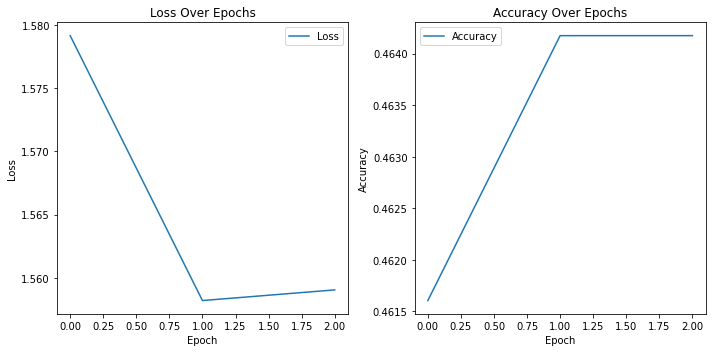

Train CNNBiLSTM+EGAT given 15 epochs - Elapsed time: 108.74697637557983 seconds
Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 64]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.4750
Recall: 1.0000
F1 Score: 0.6441

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: macro avg
Precision: 0.0679
Recall: 0.1429
F1 Score: 0.0920

Class: weighted avg
Precision: 0.2256
Recall: 0.4750
F1 Score: 0.3059

Accuracy: 0.4750
Weighted F1 Score: 0.3059


In [48]:
# enable oversampling by setting isOversample=True
X_trainTensor, Y_trainTensor = prep_data(torch.tensor(trainFeatures6), y_train, False)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=50, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Train CNNBiLSTM+EGAT given 15 epochs - Elapsed time: {elapsed_time} seconds")
X_testTensor, Y_testTensor = prep_data(testFeatures6, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 600]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.4750
Recall: 1.0000
F1 Score: 0.6441

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: macro avg
Precision: 0.0679
Recall: 0.1429
F1 Score: 0.0920

Class: weighted avg
Precision: 0.2256
Recall: 0.4750
F1 Score: 0.3059

Accuracy: 0.4750
Weighted F1 Score: 0.3059


C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


<h4> Train and validate CNNBiLSTM+GAT (⭕️ Oversample)

C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 5960 occurrences
Label disgust: 5960 occurrences
Label fear: 5960 occurrences
Label joy: 5960 occurrences
Label neutral: 5960 occurrences
Label sadness: 5960 occurrences
Label surprise: 5960 occurrences
torch.Size([41720, 600]) torch.Size([41720])


Epoch 1/11:   0%|                                                                            | 0/41720 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\3756449778.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\3756449778.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/11], Loss: 0.5595, Accuracy: 0.8228


Epoch [2/11], Loss: 0.5732, Accuracy: 0.8187
Training terminated early at epoch 2 due to small change in loss


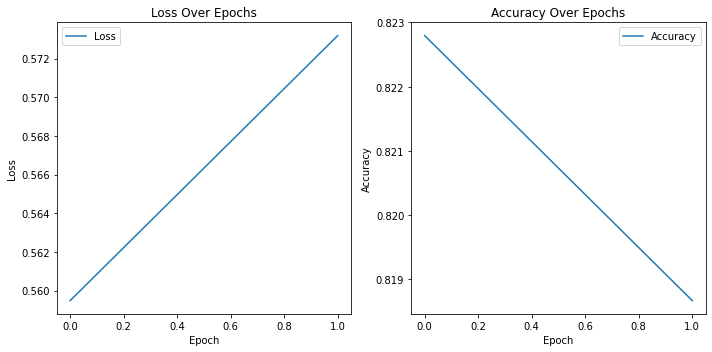

Trai CNNBiLSTM+GAT given 15 epochs - Elapsed time: 869.8773131370544 seconds
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1429
Recall: 1.0000
F1 Score: 0.2500

Class: macro avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Class: weighted avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Accuracy: 0.1429
Weighted F1 Score: 0.0357


In [40]:
X_trainTensor, Y_trainTensor = prep_data(concatenatedRepresentationTrain1, y_train, True)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=11, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Trai CNNBiLSTM+GAT given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [42]:
# Predict the test set
X_testTensor, Y_testTensor = prep_data(concatenatedRepresentationTest1, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 600]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1035
Recall: 1.0000
F1 Score: 0.1876

Class: macro avg
Precision: 0.0148
Recall: 0.1429
F1 Score: 0.0268

Class: weighted avg
Precision: 0.0107
Recall: 0.1035
F1 Score: 0.0194

Accuracy: 0.1035
Weighted F1 Score: 0.0194


C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


<h4> Train and validate CNNBiLSTM (❌ feature selection ⭕️ Oversample) given 2 epochs

C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 5960 occurrences
Label disgust: 5960 occurrences
Label fear: 5960 occurrences
Label joy: 5960 occurrences
Label neutral: 5960 occurrences
Label sadness: 5960 occurrences
Label surprise: 5960 occurrences
torch.Size([41720, 300]) torch.Size([41720])


Epoch 1/11:   0%|                                                                            | 0/41720 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\3756449778.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\3756449778.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/11], Loss: 0.5492, Accuracy: 0.8229


Epoch [2/11], Loss: 0.5942, Accuracy: 0.8044
Training terminated early at epoch 2 due to small change in loss


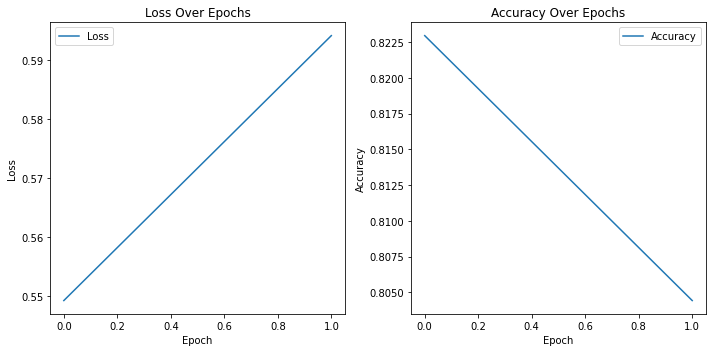

Training CNNBiLSTM given 15 epochs - Elapsed time: 612.7316813468933 seconds
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1429
Recall: 1.0000
F1 Score: 0.2500

Class: macro avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Class: weighted avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Accuracy: 0.1429
Weighted F1 Score: 0.0357


In [43]:
X_trainTensor, Y_trainTensor = prep_data(rawCtxRepresentationTrain, y_train, True)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=11, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training CNNBiLSTM given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [44]:
# Predict the test set
X_testTensor, Y_testTensor = prep_data(rawCtxRepresentationTest, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 300]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1035
Recall: 1.0000
F1 Score: 0.1876

Class: macro avg
Precision: 0.0148
Recall: 0.1429
F1 Score: 0.0268

Class: weighted avg
Precision: 0.0107
Recall: 0.1035
F1 Score: 0.0194

Accuracy: 0.1035
Weighted F1 Score: 0.0194


C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


<h4> Train and validate BERT+EGAT (⭕️ feature selection, ⭕️ Oversample) given 11 epochs

C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 5960 occurrences
Label disgust: 5960 occurrences
Label fear: 5960 occurrences
Label joy: 5960 occurrences
Label neutral: 5960 occurrences
Label sadness: 5960 occurrences
Label surprise: 5960 occurrences
torch.Size([41720, 131]) torch.Size([41720])


Epoch 1/5:   0%|                                                                             | 0/41720 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\1948670983.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\1948670983.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/5], Loss: 0.7708, Accuracy: 0.7471


Epoch [2/5], Loss: 0.7725, Accuracy: 0.7529
Training terminated early at epoch 2 due to small change in loss


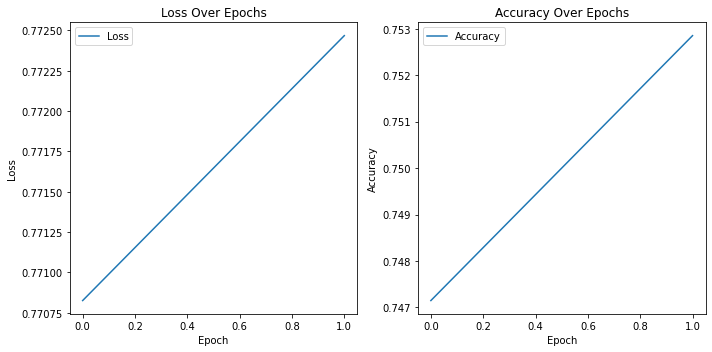

Training CNNBiLSTM given 15 epochs - Elapsed time: 310.8277277946472 seconds
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1429
Recall: 1.0000
F1 Score: 0.2500

Class: macro avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Class: weighted avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Accuracy: 0.1429
Weighted F1 Score: 0.0357


In [56]:
X_trainTensor, Y_trainTensor = prep_data(concatenatedSelectedRepresentationTrain1, y_train, True)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=5, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training CNNBiLSTM given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [ ]:
# # Predict the test set
X_testTensor, Y_testTensor = prep_data(concatenatedSelectedRepresentationTest1, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

<h4> Train and validate BERT+EGAT (⭕️ feature selection, ❌ Oversample) given 11 epochs¶

C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 131]) torch.Size([12840])


Epoch 1/11:   0%|                                                                            | 0/12840 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\1948670983.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\1948670983.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/11], Loss: 1.5805, Accuracy: 0.4622


Epoch [2/11], Loss: 1.5517, Accuracy: 0.4642


Epoch [3/11], Loss: 1.5454, Accuracy: 0.4642
Training terminated early at epoch 3 due to small change in loss


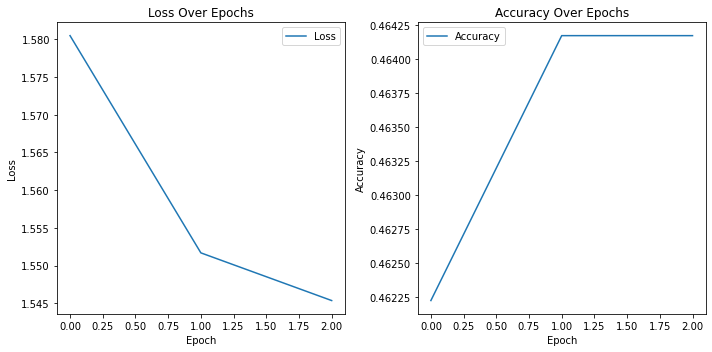

Training CNNBiLSTM given 15 epochs - Elapsed time: 107.85777187347412 seconds
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.4642
Recall: 1.0000
F1 Score: 0.6340

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: macro avg
Precision: 0.0663
Recall: 0.1429
F1 Score: 0.0906

Class: weighted avg
Precision: 0.2155
Recall: 0.4642
F1 Score: 0.2943

Accuracy: 0.4642
Weighted F1 Score: 0.2943


In [53]:
X_trainTensor, Y_trainTensor = prep_data(concatenatedSelectedRepresentationTrain1, y_train, False)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=11, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training CNNBiLSTM given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [54]:
# # Predict the test set
X_testTensor, Y_testTensor = prep_data(concatenatedSelectedRepresentationTest1, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 131]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.4750
Recall: 1.0000
F1 Score: 0.6441

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: macro avg
Precision: 0.0679
Recall: 0.1429
F1 Score: 0.0920

Class: weighted avg
Precision: 0.2256
Recall: 0.4750
F1 Score: 0.3059

Accuracy: 0.4750
Weighted F1 Score: 0.3059


C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()
